In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from interpret import show
import lime
import lime.lime_tabular
import shap
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src') 

from data_pipeline.extractor import execute_query
from gams.logistic_gam import train_logistic_gam_model
from gams.ebm_gam import train_ebm_model, display_global_explanation_with_full_feature_names
from ml_models.random_forest import train_random_forest_model
from ml_models.evalauion_results import evaluate_model
from ml_models.xgb_model import train_xgboost_model

In [2]:
query = """
SELECT s.*, a.hospital_expire_flag as mortality
FROM apsiii s
LEFT JOIN admissions a
ON s.subject_id = a.subject_id
AND s.hadm_id = a.hadm_id;
"""

df = execute_query(query)

# 1. apsiii Traditional Scoring Model

In [3]:
df_apsiii = df.copy()
df_apsiii['apsiii_binary'] = (df_apsiii['apsiii_prob'] >= 0.5).astype(int)

# Exclude specific columns
df_apsiii_filtered = df_apsiii.drop(columns=['subject_id', 'hadm_id', 'icustay_id', 'apsiii'])

# Replace NaNs with 0
df_apsiii_filtered = df_apsiii_filtered.fillna(0)

# Separate majority and minority classes
df_apsiii_majority = df_apsiii_filtered[df_apsiii_filtered.mortality == 0]
df_apsiii_minority = df_apsiii_filtered[df_apsiii_filtered.mortality == 1]

# Oversample minority class to twice its size
df_apsiii_minority_oversampled = resample(df_apsiii_minority,
                                   replace=True,     # sample with replacement
                                   n_samples=2*len(df_apsiii_minority),  # double the minority class size
                                   random_state=42)  # reproducible results

# Downsample majority class to match the original minority class size
df_apsiii_majority_downsampled = resample(df_apsiii_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_apsiii_minority_oversampled),  # to match original minority class size
                                   random_state=42)  # reproducible results

# Combine downsampled majority class with oversampled minority class
df_apsiii_balanced = pd.concat([df_apsiii_majority_downsampled, df_apsiii_minority_oversampled])

# Separate features and target variable
y_true = df_apsiii_balanced['mortality']

apsiii_pred_on_X = df_apsiii_balanced[["apsiii_binary","apsiii_prob"]]

# Split the balanced data into training and test sets
X_train_apsiii_pred, X_test_apsiii_pred, y_train, y_test = train_test_split(apsiii_pred_on_X, y_true, test_size=0.2, random_state=42, stratify=y_true)

# Print class distribution after the split
print("Training set class distribution:")
print(y_train.value_counts())

print("Test set class distribution:")
print(y_test.value_counts())

Training set class distribution:
mortality
0    10574
1    10574
Name: count, dtype: int64
Test set class distribution:
mortality
1    2644
0    2644
Name: count, dtype: int64


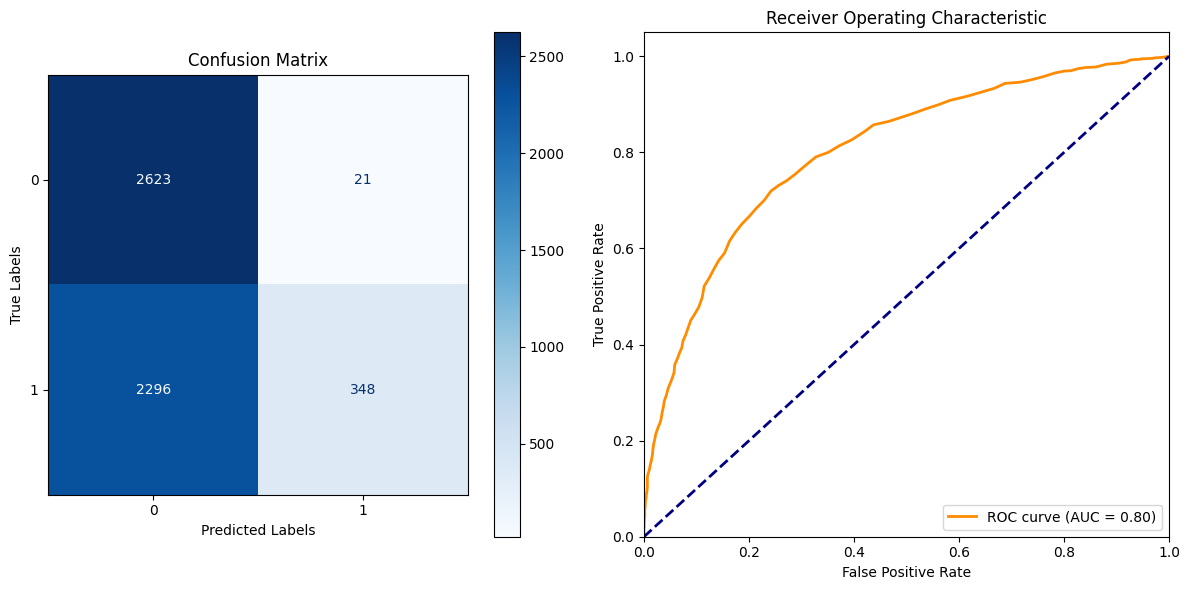

apsiii Traditional Scoring Model:

ROC AUC Score: 0.8019
Precision-Recall AUC Score: 0.8015
Training Accuracy: 0.5647
Test Accuracy: 0.5618
F1 Score: 0.2310

Confusion Matrix:
[[2623   21]
 [2296  348]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.99      0.69      2644
           1       0.94      0.13      0.23      2644

    accuracy                           0.56      5288
   macro avg       0.74      0.56      0.46      5288
weighted avg       0.74      0.56      0.46      5288



In [4]:
y_pred_apsiii = X_test_apsiii_pred['apsiii_binary']
y_pred_prob_apsiii = X_test_apsiii_pred['apsiii_prob']

evaluation_results_apsiii = evaluate_model(y_test, y_pred_apsiii, y_pred_prob_apsiii)

# Print the ROC AUC and Precision-Recall AUC Scores
print("apsiii Traditional Scoring Model:\n")
print(f"ROC AUC Score: {evaluation_results_apsiii['roc_auc']:.4f}")
print(f"Precision-Recall AUC Score: {evaluation_results_apsiii['roc_prc']:.4f}")
print(f"Training Accuracy: {accuracy_score(y_train,X_train_apsiii_pred['apsiii_binary']):.4f}")
print(f"Test Accuracy: {evaluation_results_apsiii['test_accuracy']:.4f}")
print(f"F1 Score: {evaluation_results_apsiii['f1_score']:.4f}")

# Print the Confusion Matrix
print("\nConfusion Matrix:")
print(evaluation_results_apsiii['confusion_matrix'])

report_apsiii = evaluation_results_apsiii['classification_report']
print("Classification Report:\n", report_apsiii)

# Train-Test Split and Standardization

In [5]:
df_models = df.copy()

# Exclude specific columns
df_filtered = df_models.drop(columns=['subject_id', 'hadm_id', 'icustay_id', 'apsiii', 'apsiii_prob'])

# Replace NaNs with 0
df_filtered = df_filtered.fillna(0)

# Separate majority and minority classes
df_majority = df_filtered[df_filtered.mortality == 0]
df_minority = df_filtered[df_filtered.mortality == 1]

# Oversample minority class to twice its size
df_minority_oversampled = resample(df_minority,
                                   replace=True,     # sample with replacement
                                   n_samples=2*len(df_minority),  # double the minority class size
                                   random_state=42)  # reproducible results

# Downsample majority class to match the original minority class size
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority_oversampled),  # to match original minority class size
                                   random_state=42)  # reproducible results

# Combine downsampled majority class with oversampled minority class
df_balanced = pd.concat([df_majority_downsampled, df_minority_oversampled])

# Separate features and target variable
y = df_balanced['mortality']
X = df_balanced.drop(columns=['mortality'])

# Split the balanced data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print class distribution after the split
print("Training set class distribution:")
print(y_train.value_counts())

print("Test set class distribution:")
print(y_test.value_counts())

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set class distribution:
mortality
0    10574
1    10574
Name: count, dtype: int64
Test set class distribution:
mortality
1    2644
0    2644
Name: count, dtype: int64


# 2. LogisticGam Model

In [6]:
# Save the best configurations to a JSON file
config_file_path = Path("../hyperparameter_tuning_optuna/logisticgam_apsiii_balanced_data_best_configs.json")

# Load the saved configuration (if it exists)
if config_file_path.exists():
    with open(config_file_path, "r") as config_file:
        best_configs = json.load(config_file)

best_params = best_configs["best_params"]

terms_option = best_params["terms_option"]
max_iter = best_params["max_iter"]
tol = best_params["tol"]
fit_intercept = best_params["fit_intercept"]

print(json.dumps(best_params, indent=4))

{
    "terms_option": "auto",
    "max_iter": 368,
    "tol": 0.069513604993303,
    "fit_intercept": false
}


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     81.1458
Link Function:                        LogitLink Log Likelihood:                                -10569.8142
Number of Samples:                        21148 AIC:                                            21301.9201
                                                AICc:                                           21302.5686
                                                UBRE:                                               3.0103
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2789
Feature Function                  Lam

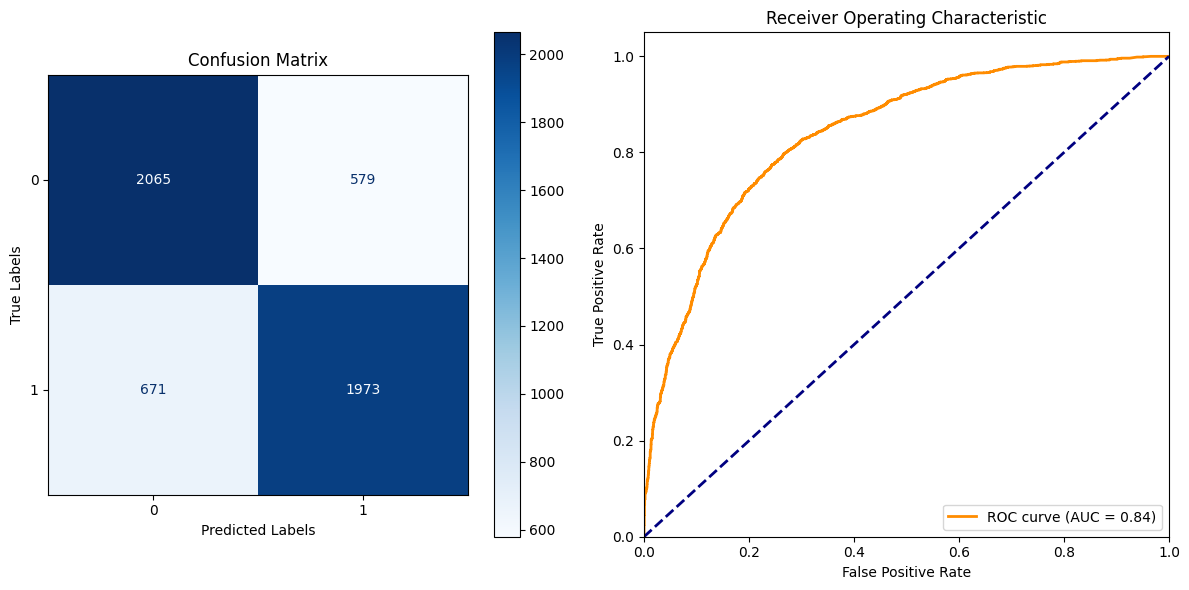

LogisticGAM Model:

ROC AUC Score: 0.8390
Precision-Recall AUC Score: 0.8323
Training Accuracy: 0.7585
Test Accuracy: 0.7636
F1 Score: 0.7594

Confusion Matrix:
[[2065  579]
 [ 671 1973]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.77      2644
           1       0.77      0.75      0.76      2644

    accuracy                           0.76      5288
   macro avg       0.76      0.76      0.76      5288
weighted avg       0.76      0.76      0.76      5288



In [7]:
model_lr, results_lr = train_logistic_gam_model(X_train_scaled, y_train, X_test_scaled, terms=terms_option, 
                                                max_iter=max_iter, tol=tol, fit_intercept=fit_intercept, include_summary=True)

evaluation_results_lr = evaluate_model(y_test, results_lr['y_pred'], results_lr['y_pred_prob'])

# Print the ROC AUC and Precision-Recall AUC Scores
print("LogisticGAM Model:\n")
print(f"ROC AUC Score: {evaluation_results_lr['roc_auc']:.4f}")
print(f"Precision-Recall AUC Score: {evaluation_results_lr['roc_prc']:.4f}")
print(f"Training Accuracy: {results_lr['training_accuracy']:.4f}")
print(f"Test Accuracy: {evaluation_results_lr['test_accuracy']:.4f}")
print(f"F1 Score: {evaluation_results_lr['f1_score']:.4f}")


# Print the Confusion Matrix
print("\nConfusion Matrix:")
print(evaluation_results_lr['confusion_matrix'])

report_lr = evaluation_results_lr['classification_report']
print("Classification Report:\n", report_lr)

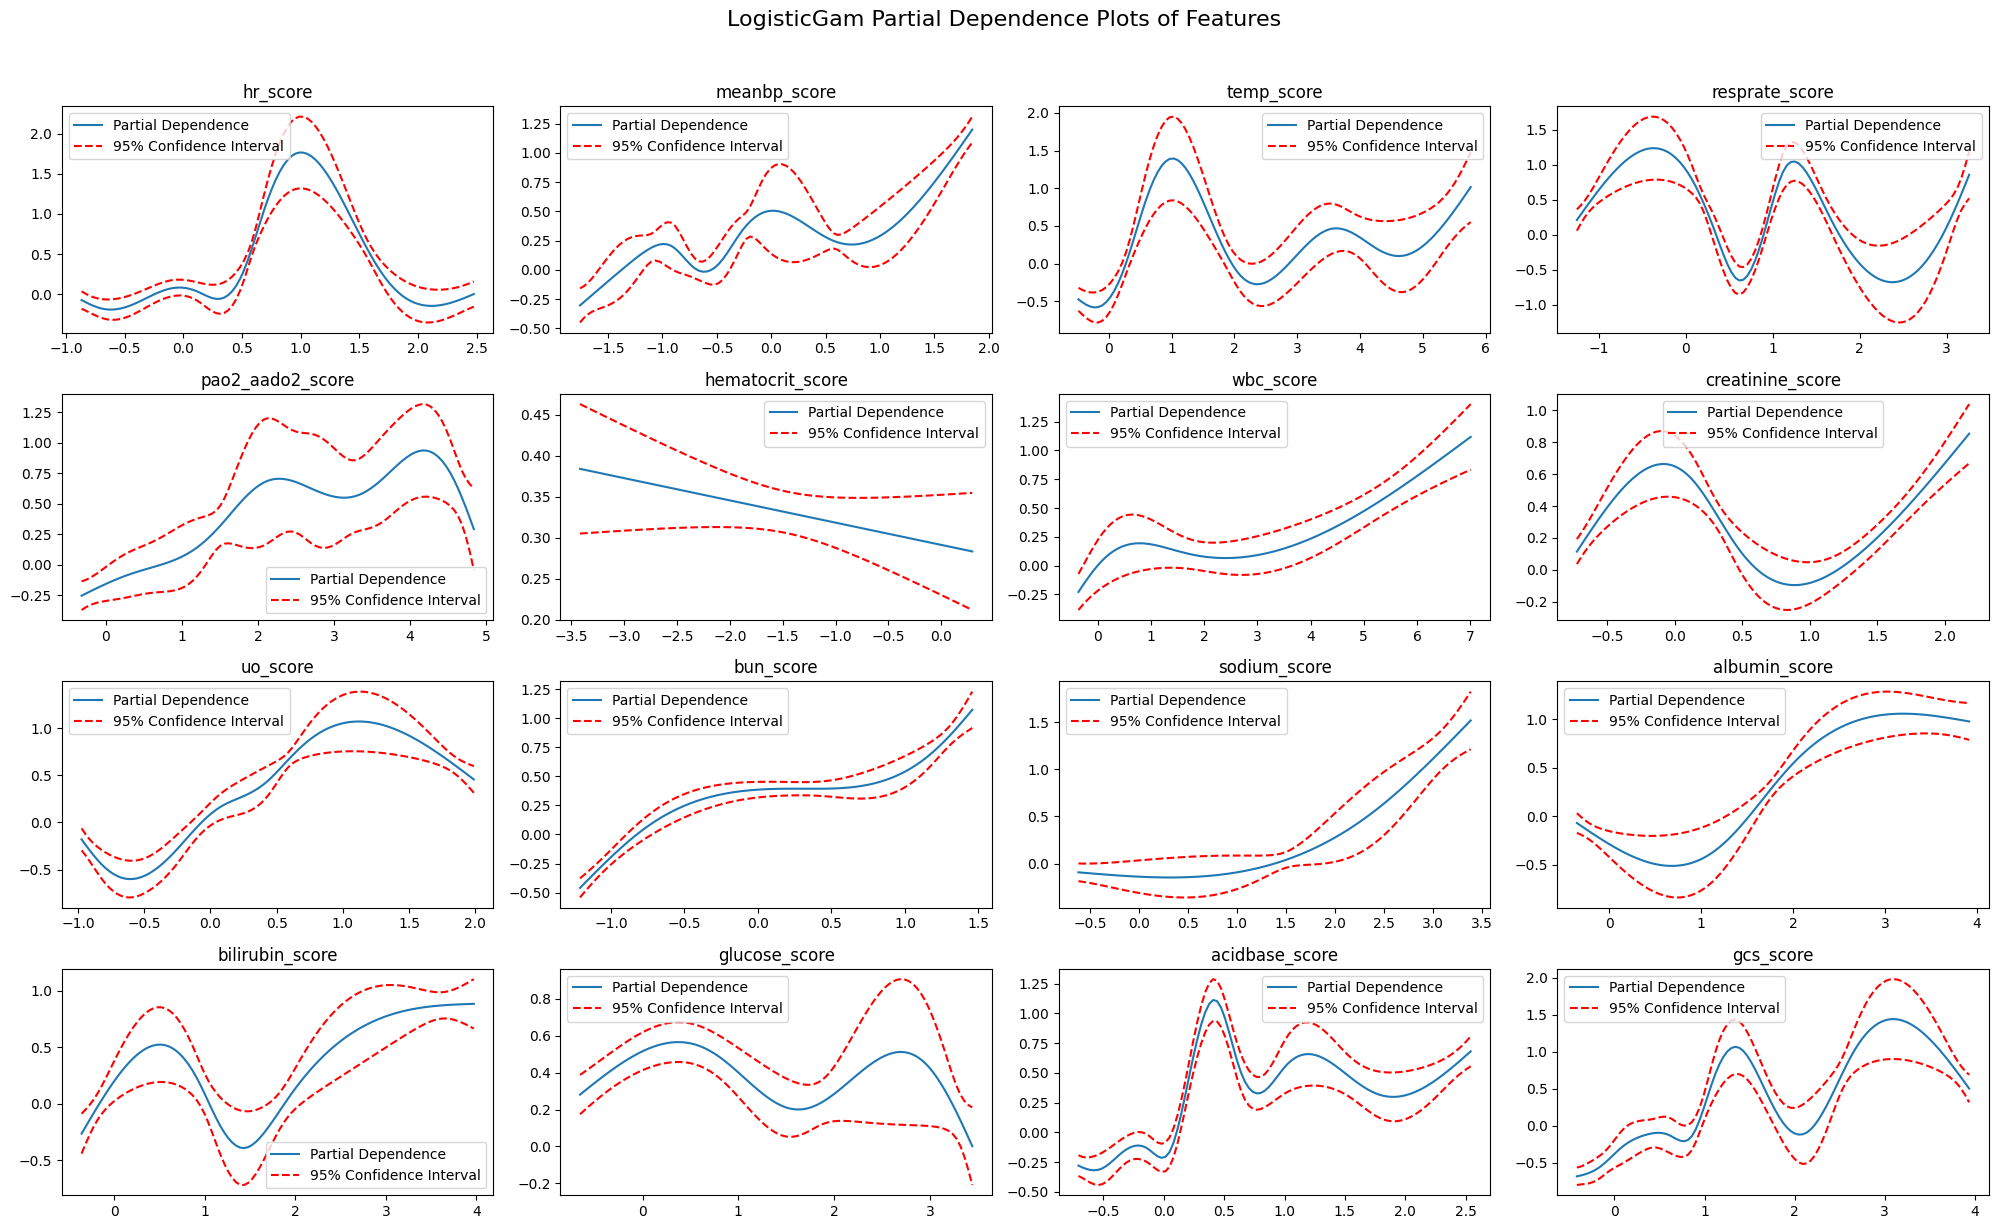

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 12))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop over the terms and plot
for i, term in enumerate(model_lr.terms):
    if term.isintercept:
        continue

    # Generate data for plotting
    XX = model_lr.generate_X_grid(term=i)
    pdep, confi = model_lr.partial_dependence(term=i, X=XX, width=0.95)

    # Get the current axis to plot on
    ax = axes[i]
    ax.plot(XX[:, term.feature], pdep, label='Partial Dependence')
    ax.plot(XX[:, term.feature], confi, c='r', ls='--')

    ax.set_title(X.columns[i])

    ax.legend(['Partial Dependence', '95% Confidence Interval'])

# Set a main title for the entire figure
fig.suptitle('LogisticGam Partial Dependence Plots of Features', fontsize=16, y=1.02)

# Adjust layout to avoid overlapping titles and labels
plt.tight_layout()
plt.show()


# 3. EBM Model

In [9]:
# Save the best configurations to a JSON file
config_file_path = Path("../hyperparameter_tuning_optuna/ebm_apsiii_balanced_data_best_configs.json")

# Load the saved configuration (if it exists)
if config_file_path.exists():
    with open(config_file_path, "r") as config_file:
        best_configs = json.load(config_file)
else:
    raise FileNotFoundError(f"Configuration file not found at {config_file_path}")

# Extracting the best parameters
best_params = best_configs["best_params"]
 
print(json.dumps(best_params, indent=4))

{
    "max_bins": 581,
    "max_interaction_bins": 47,
    "interactions": 0,
    "outer_bags": 18,
    "inner_bags": 10,
    "learning_rate": 0.04367020510396994,
    "min_samples_leaf": 96,
    "max_leaves": 5,
    "max_rounds": 10124,
    "early_stopping_rounds": 97,
    "smoothing_rounds": 386,
    "greedy_ratio": 1.3695083018257845
}


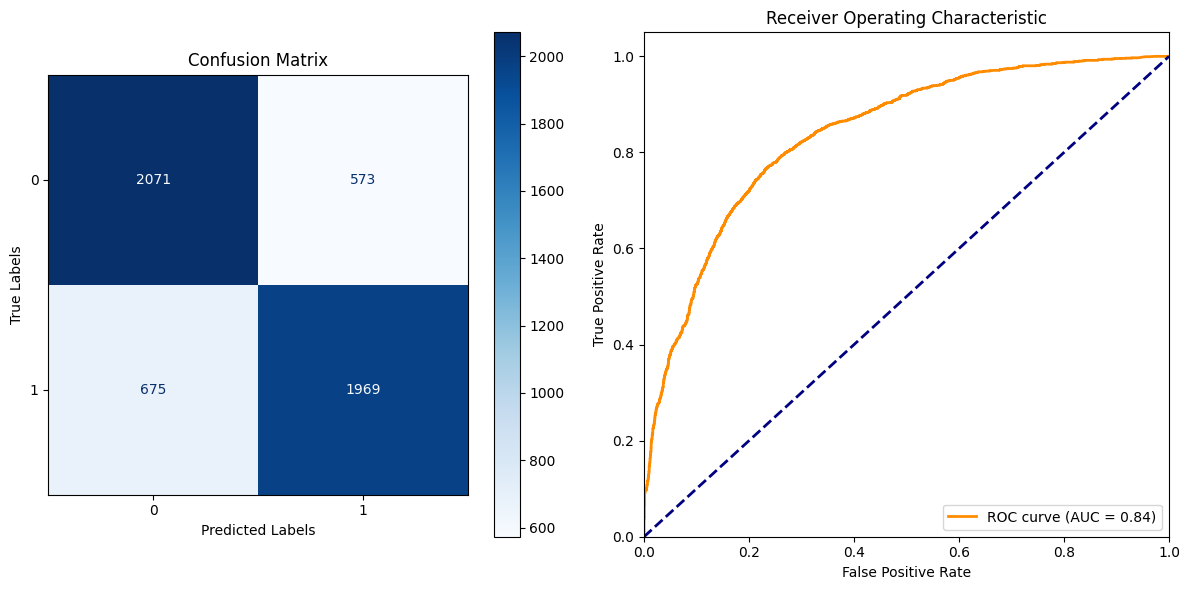

EBM Model: 

ROC AUC Score: 0.8385
Precision-Recall AUC Score: 0.8319
Training Accuracy: 0.7586
Test Accuracy: 0.7640
F1 Score: 0.7594

Confusion Matrix:
[[2071  573]
 [ 675 1969]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.77      2644
           1       0.77      0.74      0.76      2644

    accuracy                           0.76      5288
   macro avg       0.76      0.76      0.76      5288
weighted avg       0.76      0.76      0.76      5288



In [10]:
model_ebm, results_ebm = train_ebm_model(X_train_scaled, y_train, X_test_scaled, **best_params)

evaluation_results_ebm = evaluate_model(y_test, results_ebm['y_pred'], results_ebm['y_pred_prob'])

print("EBM Model: \n")
print(f"ROC AUC Score: {evaluation_results_ebm['roc_auc']:.4f}")
print(f"Precision-Recall AUC Score: {evaluation_results_ebm['roc_prc']:.4f}")
print(f"Training Accuracy: {results_ebm['training_accuracy']:.4f}")
print(f"Test Accuracy: {evaluation_results_ebm['test_accuracy']:.4f}")
print(f"F1 Score: {evaluation_results_ebm['f1_score']:.4f}")

print("\nConfusion Matrix:")
print(evaluation_results_ebm['confusion_matrix'])

report_ebm = evaluation_results_ebm['classification_report']
print("Classification Report:\n", report_ebm)

In [11]:
display_global_explanation_with_full_feature_names(model_ebm, X.columns)

<!-- http://127.0.0.1:7949/2237121798576/ -->

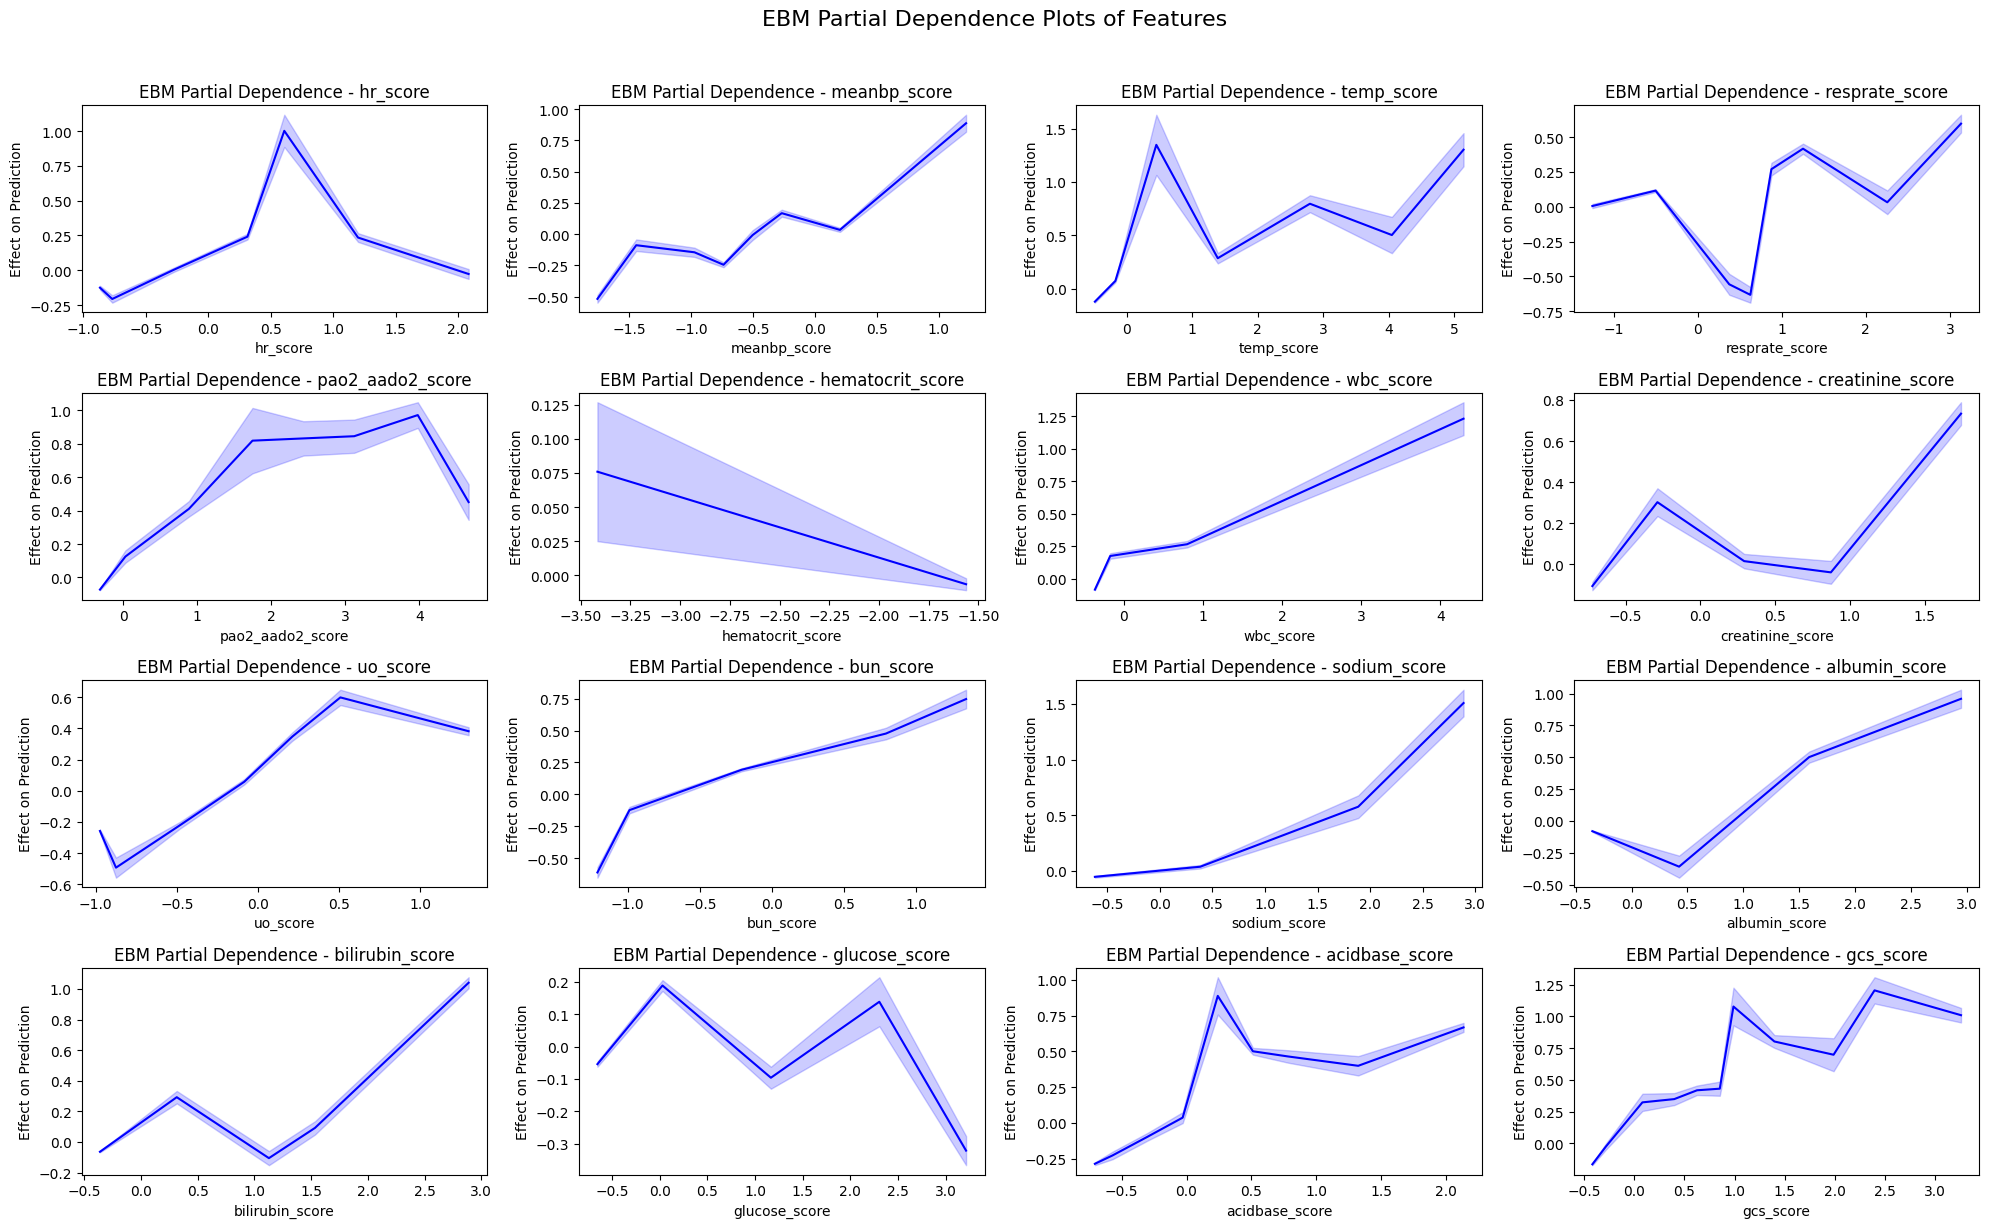

In [12]:
def plot_ebm_pdp(model_ebm, feature_to_plot, feature_names, ax):
    # Get the index of the feature to plot
    feature_idx = feature_names.index(feature_to_plot)
    
    # Obtain global explanation for the EBM model
    ebm_global = model_ebm.explain_global()
    
    # Extract data for the specified feature
    data = ebm_global.data(feature_idx)
    
    # Ensure the dimensions match for plotting
    plot_length = min(len(data['names']), len(data['scores']))
    
    # Plot the partial dependence plot for the specified feature on the given axis
    ax.plot(data['names'][:plot_length], data['scores'][:plot_length], color='blue', label='Partial Dependence')
    ax.fill_between(data['names'][:plot_length], data['lower_bounds'][:plot_length], data['upper_bounds'][:plot_length], color='blue', alpha=0.2, label='95% CI')
    
    # Set plot title and labels
    ax.set_title(f"EBM Partial Dependence - {feature_to_plot}")
    ax.set_xlabel(feature_to_plot)
    ax.set_ylabel("Effect on Prediction")

# Example Workflow
feature_names = X.columns.tolist()  # Assuming X is your original DataFrame with column names

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 12))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through all features and plot on the corresponding axes
for i, feature in enumerate(feature_names):
    if i >= len(axes):
        break  # Avoid indexing issues if there are more features than subplot slots
    plot_ebm_pdp(model_ebm, feature, feature_names, axes[i])

# Set a main title for the entire figure
fig.suptitle('EBM Partial Dependence Plots of Features', fontsize=16, y=1.02)

# Adjust layout to avoid overlapping titles and labels
plt.tight_layout()
plt.show()

# 4. Random Forest Model

In [13]:
# Save the best configurations to a JSON file
config_file_path = Path("../hyperparameter_tuning_optuna/random_forest_apsiii_best_configs.json")

# Load the saved configuration (if it exists)
if config_file_path.exists():
    with open(config_file_path, "r") as config_file:
        best_configs = json.load(config_file)
else:
    raise FileNotFoundError(f"Configuration file not found at {config_file_path}")

# Extracting the best parameters
best_params = best_configs["best_params"]
 
print(json.dumps(best_params, indent=4))

{
    "n_estimators": 173,
    "criterion": "entropy",
    "max_depth": 22,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "min_weight_fraction_leaf": 0.021718504190443414,
    "max_features": "log2",
    "max_leaf_nodes": 20,
    "min_impurity_decrease": 0.00020050960333953174,
    "bootstrap": false,
    "class_weight": "balanced_subsample",
    "ccp_alpha": 0.0010040314628222235
}


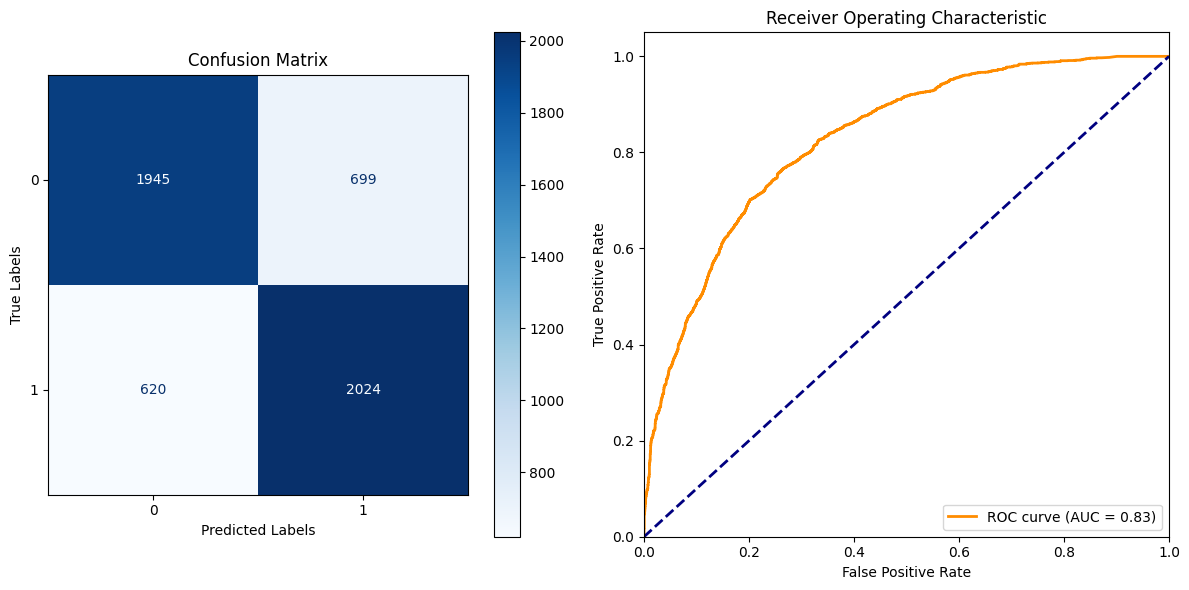

Random Forest Model: 

ROC AUC Score: 0.8280
Precision-Recall AUC Score: 0.8192
Training Accuracy: 0.7378
Test Accuracy: 0.7506
F1 Score: 0.7542

Confusion Matrix:
[[1945  699]
 [ 620 2024]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75      2644
           1       0.74      0.77      0.75      2644

    accuracy                           0.75      5288
   macro avg       0.75      0.75      0.75      5288
weighted avg       0.75      0.75      0.75      5288



In [14]:
model_rf, results_rf = train_random_forest_model(X_train_scaled, y_train, X_test_scaled, **best_params)

evaluation_results_rf = evaluate_model(y_test, results_rf['y_pred'], results_rf['y_pred_prob'])

print("Random Forest Model: \n")
print(f"ROC AUC Score: {evaluation_results_rf['roc_auc']:.4f}")
print(f"Precision-Recall AUC Score: {evaluation_results_rf['roc_prc']:.4f}")
print(f"Training Accuracy: {results_rf['training_accuracy']:.4f}")
print(f"Test Accuracy: {evaluation_results_rf['test_accuracy']:.4f}")
print(f"F1 Score: {evaluation_results_rf['f1_score']:.4f}")

print("\nConfusion Matrix:")
print(evaluation_results_rf['confusion_matrix'])

report_rf = evaluation_results_rf['classification_report']
print("Classification Report:\n", report_rf)

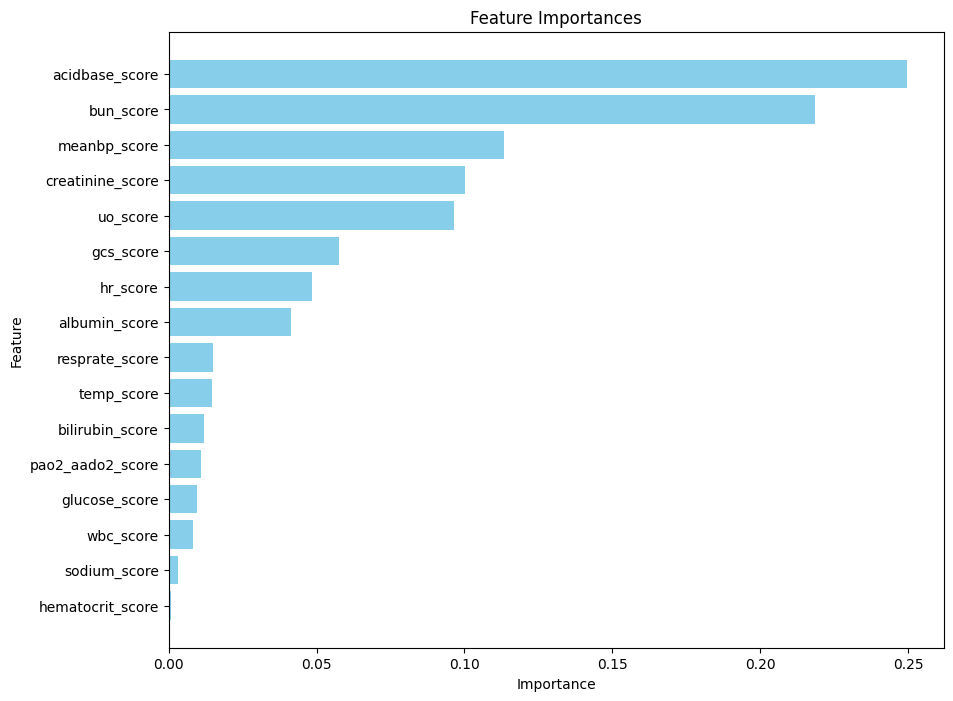

In [15]:
feature_importances_rf = model_rf.feature_importances_
feature_names_rf = X.columns
feature_importance_df_rf = pd.DataFrame({
    'Feature': feature_names_rf,
    'Importance': feature_importances_rf
})

feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df_rf['Feature'], feature_importance_df_rf['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis() 
plt.show()

# 5. XGBoost Model

In [16]:
# File path to the JSON file with the best configurations
config_file_path = Path("../hyperparameter_tuning_optuna/xgboost_apsiii_balanced_data_best_configs.json")

# Load the saved configuration (if it exists)
if config_file_path.exists():
    with open(config_file_path, "r") as config_file:
        best_configs = json.load(config_file)
else:
    raise FileNotFoundError(f"Configuration file not found at {config_file_path}")

# Extracting the best parameters
best_params = best_configs["best_params"]
print(json.dumps(best_params, indent=4))

{
    "learning_rate": 0.2896027779817393,
    "max_depth": 10,
    "min_child_weight": 1.2646569686590456,
    "subsample": 0.9323226684735562,
    "colsample_bytree": 0.6961040747673508,
    "reg_alpha": 1.046220932209122,
    "reg_lambda": 0.8626759113789945,
    "scale_pos_weight": 4.541731121439532,
    "n_estimators": 365,
    "gamma": 0.004571785264911518,
    "max_delta_step": 0.6586642621092984
}


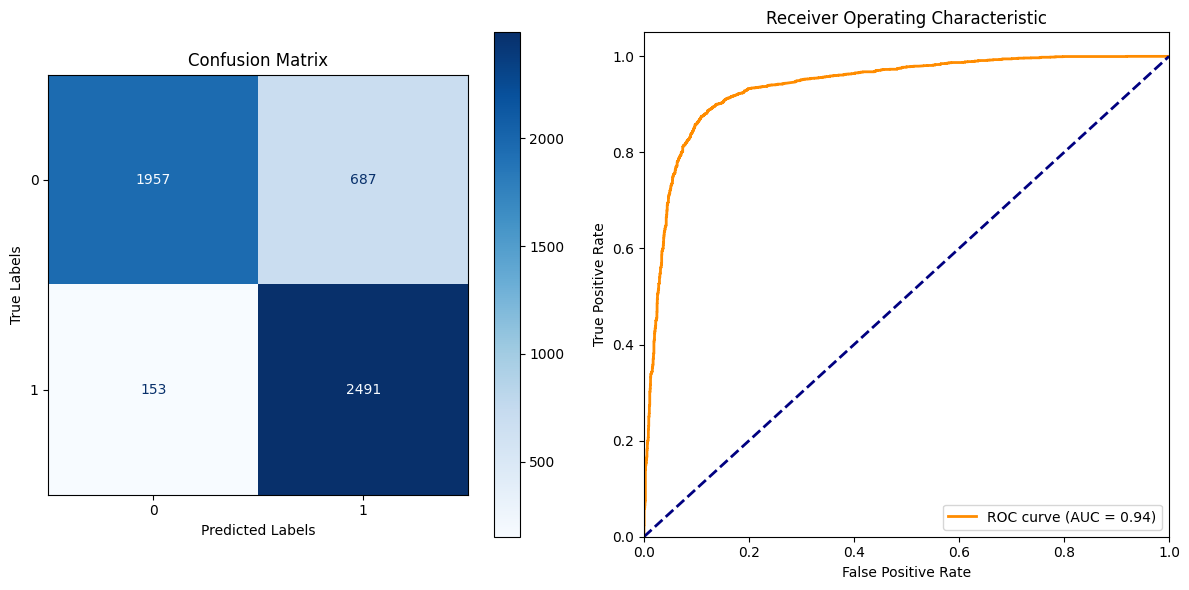

XGBoost Model: 

ROC AUC Score: 0.9370
Precision-Recall AUC Score: 0.9292
Training Accuracy: 0.9782
Test Accuracy: 0.8411
F1 Score: 0.8557

Confusion Matrix:
[[1957  687]
 [ 153 2491]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.74      0.82      2644
           1       0.78      0.94      0.86      2644

    accuracy                           0.84      5288
   macro avg       0.86      0.84      0.84      5288
weighted avg       0.86      0.84      0.84      5288



In [17]:
model_xgb, results_xgb = train_xgboost_model(X_train_scaled, y_train, X_test_scaled,**best_params)

evaluation_results_xgb = evaluate_model(y_test, results_xgb['y_pred'], results_xgb['y_pred_prob'])

print("XGBoost Model: \n")
print(f"ROC AUC Score: {evaluation_results_xgb['roc_auc']:.4f}")
print(f"Precision-Recall AUC Score: {evaluation_results_xgb['roc_prc']:.4f}")
print(f"Training Accuracy: {results_xgb['training_accuracy']:.4f}")
print(f"Test Accuracy: {evaluation_results_xgb['test_accuracy']:.4f}")
print(f"F1 Score: {evaluation_results_xgb['f1_score']:.4f}")

print("\nConfusion Matrix:")
print(evaluation_results_xgb['confusion_matrix'])

report_xgb = evaluation_results_xgb['classification_report']
print("Classification Report:\n", report_xgb)

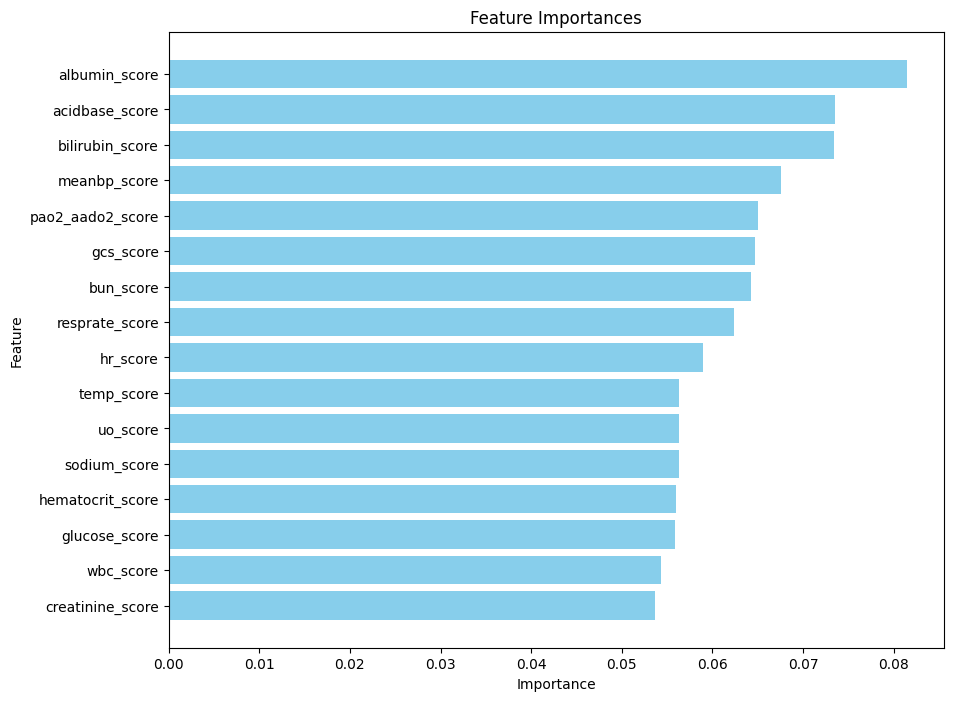

In [18]:
feature_importances_xgb = model_xgb.feature_importances_
feature_names_xgb = X.columns
feature_importance_df_xgb = pd.DataFrame({
    'Feature': feature_names_xgb,
    'Importance': feature_importances_xgb
})

feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df_xgb['Feature'], feature_importance_df_xgb['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis() 
plt.show()

# Thanks